<a href="https://colab.research.google.com/github/vishalrk1/tensorflow_Pytorch/blob/main/pytorch_practice_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Faction MNIST

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn 
import torchvision
import torchvision.transforms as transforms

from datetime import datetime

In [ ]:
train_dataset = torchvision.datasets.FashionMNIST(
    root='.',
    train = True,
    transform = transforms.ToTensor(),
    download = True,
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
test_dataset = torchvision.datasets.FashionMNIST(
    root = '.',
    train = False,
    transform = transforms.ToTensor(),
    download = True,
)

In [ ]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [ ]:
train_dataset.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [ ]:
train_dataset.class_to_idx

{'Ankle boot': 9,
 'Bag': 8,
 'Coat': 4,
 'Dress': 3,
 'Pullover': 2,
 'Sandal': 5,
 'Shirt': 6,
 'Sneaker': 7,
 'T-shirt/top': 0,
 'Trouser': 1}

In [ ]:
# number of classes
k = len(set(train_dataset.targets.numpy()))
print(f'Number of classes {k}')

Number of classes 10


## Bulding Model

In [ ]:
class CNN(nn.Module):

  def __init__(self, k):
    super(CNN, self).__init__()
    self.conv_layers = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
        nn.ReLU(),
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
        nn.ReLU(),
    )

    self.dense_layers = nn.Sequential(
        nn.Dropout(0.2),
        nn.Linear(128*2*2, 512),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(512, k),
    )

  def forward(self, X):
    out = self.conv_layers(X)
    out = out.view(out.size(0), -1)
    out = self.dense_layers(out)
    return out

In [ ]:
model = CNN(k)
model

CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

## Moving Model ot gpu if we have any

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

cuda:0


CNN(
  (conv_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
    (5): ReLU()
  )
  (dense_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

## Creating Dataloaders

In [ ]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size = batch_size,
    shuffle = True,
)

test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset,
    batch_size = batch_size,
    shuffle = False
)

In [ ]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []

    for inputs, targets in train_loader:
      # moving data to gpu
      inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradient
      optimizer.zero_grad()

      # Forward Pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Backward and optimize 
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # get train loss and test loss
    train_loss = np.mean(train_loss)

    test_loss = []
    for inputs, targets in test_loader:
      # moving data to gpu
      inputs, targets = inputs.to(device), targets.to(device)

      # model prediction 
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # saving losses 
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f},     Test Loss {test_loss:.4f}, Duration: {dt}')

  return train_losses, test_losses


In [ ]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=15)

Epoch 1/15, Train Loss: 0.6456,     Test Loss 0.4912, Duration: 0:00:13.765650
Epoch 2/15, Train Loss: 0.4275,     Test Loss 0.4267, Duration: 0:00:13.128112
Epoch 3/15, Train Loss: 0.3689,     Test Loss 0.3774, Duration: 0:00:13.300193
Epoch 4/15, Train Loss: 0.3330,     Test Loss 0.3647, Duration: 0:00:13.365061
Epoch 5/15, Train Loss: 0.3071,     Test Loss 0.3337, Duration: 0:00:13.435813
Epoch 6/15, Train Loss: 0.2863,     Test Loss 0.3330, Duration: 0:00:13.334070
Epoch 7/15, Train Loss: 0.2665,     Test Loss 0.3124, Duration: 0:00:13.274602
Epoch 8/15, Train Loss: 0.2502,     Test Loss 0.3014, Duration: 0:00:13.362942
Epoch 9/15, Train Loss: 0.2362,     Test Loss 0.3125, Duration: 0:00:13.431917
Epoch 10/15, Train Loss: 0.2223,     Test Loss 0.2997, Duration: 0:00:13.390954
Epoch 11/15, Train Loss: 0.2114,     Test Loss 0.3019, Duration: 0:00:13.356704
Epoch 12/15, Train Loss: 0.1969,     Test Loss 0.3086, Duration: 0:00:13.387593
Epoch 13/15, Train Loss: 0.1859,     Test Loss 0.

In [ ]:
def plot_losses(train_losses, test_losses):
  plt.plot(train_losses, label='Train Loss')
  plt.plot(test_losses, label='Test Loss')
  plt.legend()
  plt.show()

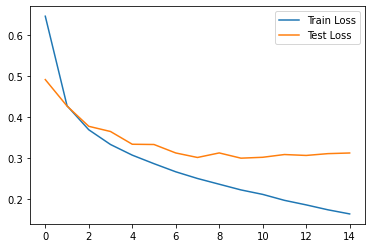

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.show()

## Calculating Accuracy of Model

In [ ]:
def calculate_acc(model, loader):
  n_correct = 0
  n_total = 0

  for inputs, targets in loader:
    # moving data to gpu
    inputs, targets = inputs.to(device), targets.to(device)

    # Forward pass
    outputs = model(inputs)

    # Getting prediction
    # torch max returns both max and argmax
    _, preds = torch.max(outputs, 1)

    # Updating counts
    n_correct += (preds == targets).sum().item()
    n_total += targets.shape[0] 

  acc = n_correct / n_total
  return acc

In [ ]:
train_acc = calculate_acc(model, train_loader)
print(f'Train Accuracy: {train_acc:.4f}')

Train Accuracy: 0.9452


In [ ]:
test_acc = calculate_acc(model, test_loader)
print(f'test Accuracy: {test_acc:.4f}')

test Accuracy: 0.8980


# CIFAR Dataset

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn 
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from datetime import datetime

In [ ]:
custom_transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(p=0.2),
    torchvision.transforms.RandomRotation(10),
    torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.ToTensor(),
])

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(
    root = '.',
    train = True,
    transform = custom_transform,
    download = True
)

test_dataset = torchvision.datasets.CIFAR10(
    root = '.',
    train = False,
    transform = transforms.ToTensor(),
    download = True
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [ ]:
train_dataset.data.shape

(50000, 32, 32, 3)

In [ ]:
train_dataset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [ ]:
# train_dataset.targets

In [ ]:
k = len(set(train_dataset.targets))
k

10

In [ ]:
BATCH_SIZE = 128 

train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = True,
)

test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
)

In [ ]:
for i, t in train_loader:
  img = i
  break

In [ ]:
img.shape

torch.Size([128, 3, 32, 32])

In [ ]:
class CNN(nn.Module):

  def __init__(self, k):
    super(CNN, self).__init__()

    # defining Conv layers
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels= 3, out_channels= 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(32, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2),
    )

    self.conv2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2),
    )

    self.conv3 = nn.Sequential(
        nn.Conv2d(64, 128, kernel_size=3,padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.Conv2d(128, 128, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2),
    )

    # defining th linear layers
    self.fc1 = nn.Linear(128*4*4, 1024)
    self.fc2 = nn.Linear(1024, k)

  def forward(self, X):
    x = self.conv1(X)
    x = self.conv2(x)
    x = self.conv3(x)
    x = x.view(x.size(0), -1)
    x = F.dropout(x, p=0.5)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, p=0.2)
    x = self.fc2(x)
    return x

In [ ]:
model = CNN(k)
model

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model.to(device)

cuda:0


CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel

In [ ]:
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
def batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    t0 = datetime.now()
    train_loss = []

    for inputs, targets in train_loader:
      # moving data to gpu
      inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradient
      optimizer.zero_grad()

      # Forward Pass
      outputs = model(inputs)
      loss = criterion(outputs, targets)

      # Backward and optimize 
      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    # get train loss and test loss
    train_loss = np.mean(train_loss)

    test_loss = []
    for inputs, targets in test_loader:
      # moving data to gpu
      inputs, targets = inputs.to(device), targets.to(device)

      # model prediction 
      outputs = model(inputs)
      loss = criterion(outputs, targets)
      test_loss.append(loss.item())
    test_loss = np.mean(test_loss)

    # saving losses 
    train_losses[it] = train_loss
    test_losses[it] = test_loss
    
    dt = datetime.now() - t0
    print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f},     Test Loss {test_loss:.4f}, Duration: {dt}')

  return train_losses, test_losses

In [ ]:
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs=30)

KeyboardInterrupt: ignored

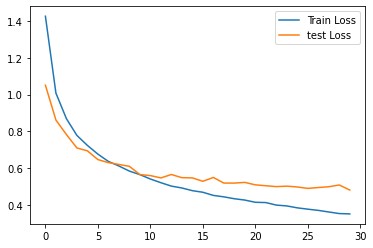

In [ ]:
plt.plot(train_losses, label = 'Train Loss')
plt.plot(test_losses, label = 'test Loss')
plt.legend()
plt.show()

In [ ]:
def calculate_acc(model, loader):
  n_correct = 0
  n_total = 0

  for inputs, targets in loader:
    # moving data to gpu
    inputs, targets = inputs.to(device), targets.to(device)

    # Forward pass
    outputs = model(inputs)

    # Getting prediction
    # torch max returns both max and argmax
    _, preds = torch.max(outputs, 1)

    # Updating counts
    n_correct += (preds == targets).sum().item()
    n_total += targets.shape[0] 

  acc = n_correct / n_total
  return acc

In [ ]:
train_acc = calculate_acc(model, train_loader)
print(f'Train Accuracy: {train_acc:.4f}')

test_acc = calculate_acc(model, test_loader)
print(f'Train Accuracy: {test_acc:.4f}')

Train Accuracy: 0.8818
Train Accuracy: 0.8482


In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
        
    print(cm)
    
    plt.imshow(cm,interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()  
    

Confusion matrix, without normalization
[[871   7  44  12   6   1   6  11  23  19]
 [ 12 942   2   5   0   0   0   0   9  30]
 [ 39   5 789  32  62  25  31  12   1   4]
 [ 21   7  40 711  48  99  40  18   5  11]
 [ 13   1  33  23 852  16  18  39   3   2]
 [  7   1  36 122  25 745  19  35   3   7]
 [ 11   5  20  41  15   4 894   6   1   3]
 [  9   0  17  18  19  17   2 908   0  10]
 [ 71  23  10   8   2   1   5   0 850  30]
 [ 15  51   1   3   0   1   1   3   7 918]]


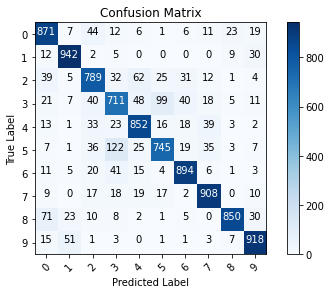

In [ ]:
x_test = test_dataset.data
y_test = np.array(test_dataset.targets)
p_test = np.array([])

for inputs, targets in test_loader:
  # moving data to gpu
  inputs, targets = inputs.to(device), targets.to(device)

  # forward Pass
  outputs = model(inputs)

  # get predictions
  _, pred = torch.max(outputs, 1)

  # update p_test
  p_test = np.concatenate((p_test, pred.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))

In [ ]:
 for i , t in test_loader:
   i, t = i.to(device), t.to(device)
   img = i
   y = t
   break

In [ ]:
img.shape

torch.Size([128, 3, 32, 32])

In [ ]:
pred = model(img)

In [ ]:
_, pred = torch.max(pred, 1)

In [ ]:
pred

tensor([3, 8, 8, 0, 6, 6, 1, 2, 3, 1, 0, 9, 5, 7, 9, 8, 5, 7, 8, 6, 7, 0, 4, 9,
        4, 4, 4, 0, 9, 6, 6, 5, 4, 3, 9, 1, 4, 1, 9, 5, 4, 6, 7, 6, 0, 9, 3, 9,
        7, 6, 9, 8, 9, 3, 8, 8, 7, 7, 3, 6, 7, 5, 6, 3, 6, 2, 1, 2, 5, 7, 2, 6,
        8, 8, 9, 2, 9, 3, 5, 8, 8, 1, 1, 7, 2, 9, 7, 7, 8, 1, 0, 6, 8, 6, 4, 3,
        6, 0, 0, 7, 4, 5, 6, 3, 1, 1, 3, 6, 8, 7, 4, 0, 2, 2, 1, 3, 0, 5, 0, 7,
        8, 3, 1, 2, 8, 0, 8, 3], device='cuda:0')